# LinkedIn Posts Data Analysis
## Notebook 03: Engagement Analysis

This notebook performs deep-dive analysis on engagement patterns, investigating what drives likes, shares, and comments.

### Objectives:
1. Investigate post length impact on engagement (with fine-grained analysis)
2. Perform statistical significance testing
3. Analyze content type × length interactions
4. Examine engagement ratios (comments, shares, likes)
5. Analyze follower count impact
6. Investigate URL patterns and host analysis
7. Identify characteristics of top-performing posts
8. Build predictive models for engagement

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import re
from urllib.parse import urlparse
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
# Load cleaned dataset
df = pd.read_csv('../output/tables/linkedin_posts_cleaned.csv')

# Parse datetime
df['postedAt'] = pd.to_datetime(df['postedAt'], format='mixed', utc=True)

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['postedAt'].min()} to {df['postedAt'].max()}")

Dataset loaded: (11227, 73)
Date range: 2024-11-22 00:27:05.461000+00:00 to 2025-11-22 22:22:05.035000+00:00


In [3]:
# Quick data check
print("\nEngagement Statistics:")
print(df[['numLikes', 'numShares', 'numComments', 'total_engagement']].describe())


Engagement Statistics:
       numLikes  numShares  numComments  total_engagement
count  11227.00   11227.00     11227.00          11227.00
mean     287.19      13.64        26.84            327.67
std      781.15      71.35       109.37            886.62
min        0.00       0.00         0.00              0.00
25%       40.00       1.00         2.00             45.00
50%      100.00       3.00         7.00            115.00
75%      258.00      10.00        23.00            294.00
max    20685.00    4235.00      9556.00          26120.00


## 2. Post Length Deep Dive

### 2.1 Investigate Empty Posts Anomaly

In [4]:
# Examine empty posts
empty_posts = df[df['length_category'] == 'Empty']

print(f"Empty posts: {len(empty_posts)}")
print(f"Average engagement: {empty_posts['total_engagement'].mean():.1f}")
print(f"\nContent type breakdown:")
print(empty_posts['primary_content_type'].value_counts())
print(f"\nTop empty posts:")
print(empty_posts.nlargest(5, 'total_engagement')[['authorName', 'primary_content_type', 'numLikes', 'numShares', 'numComments', 'total_engagement']])

# These are likely image/video posts with no caption - legitimate but skew the analysis

Empty posts: 14
Average engagement: 655.6

Content type breakdown:
primary_content_type
Article    6
Unknown    3
Video      3
Image      2
Name: count, dtype: int64

Top empty posts:
            authorName primary_content_type  numLikes  numShares  numComments  \
857        Jeff Immelt              Article      6256        140          548   
772      Parag Agrawal                Image       906          8           41   
9847      Reid Hoffman              Article       380          9           68   
5967      Nicole Quinn              Article       311          1           75   
791   Ekin Dogus Cubuk              Unknown       127         16            5   

      total_engagement  
857               6944  
772                955  
9847               457  
5967               387  
791                148  


In [5]:
# Create dataset excluding empty posts for length analysis
df_with_text = df[df['text_length'] > 0].copy()

print(f"Posts with text: {len(df_with_text)} ({len(df_with_text)/len(df)*100:.1f}%)")
print(f"Excluded empty posts: {len(df) - len(df_with_text)}")

Posts with text: 11213 (99.9%)
Excluded empty posts: 14


### 2.2 Fine-Grained Length Analysis

In [6]:
# Create fine-grained length bins (every 200 characters)
bins = list(range(0, 3001, 200))
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

df_with_text['length_bin'] = pd.cut(df_with_text['text_length'], bins=bins, labels=labels, include_lowest=True)

# Calculate engagement by length bin
length_bin_stats = df_with_text.groupby('length_bin').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

length_bin_stats.columns = ['avg_engagement', 'median_engagement', 'post_count', 'avg_likes', 'avg_shares', 'avg_comments']
length_bin_stats = length_bin_stats.reset_index()

# Only show bins with at least 10 posts
length_bin_stats_filtered = length_bin_stats[length_bin_stats['post_count'] >= 10]

print("Engagement by Length Bin (200 char intervals):")
print(length_bin_stats_filtered.to_string(index=False))

# Save results
length_bin_stats.to_csv('../output/tables/engagement_by_length_bins.csv', index=False)

Engagement by Length Bin (200 char intervals):
length_bin  avg_engagement  median_engagement  post_count  avg_likes  avg_shares  avg_comments
     0-200          122.41              38.00        2049     110.68        3.73          7.99
   200-400          285.10              89.00        2586     255.38        7.86         21.86
   400-600          302.34             109.50        1592     269.61       11.58         21.14
   600-800          399.58             130.00        1200     353.89       17.68         28.00
  800-1000          290.23             133.00         962     252.49       13.18         24.57
 1000-1200          341.46             182.00         749     296.31       15.70         29.46
 1200-1400          426.58             191.00         561     369.52       20.75         36.31
 1400-1600          687.94             250.00         379     580.27       47.75         59.92
 1600-1800          611.96             230.50         290     528.15       25.75         58.05
 18

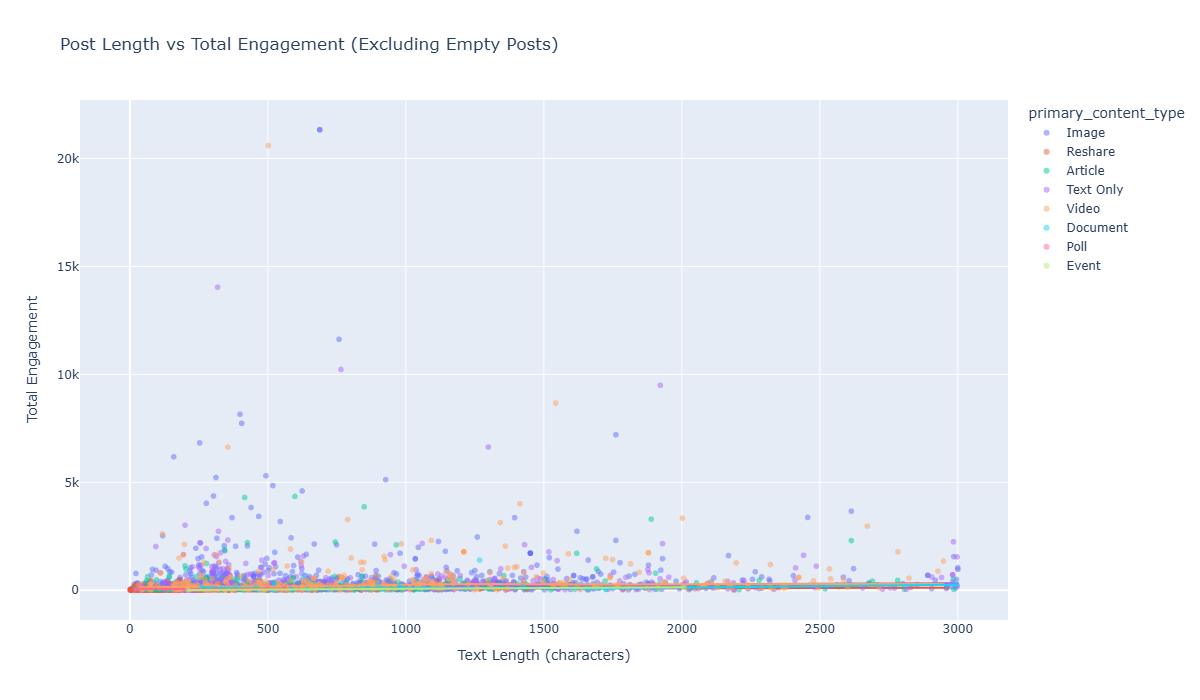

In [7]:
# Visualize length vs engagement with smooth curve
fig = px.scatter(
    df_with_text.sample(min(3000, len(df_with_text))),
    x='text_length',
    y='total_engagement',
    color='primary_content_type',
    title='Post Length vs Total Engagement (Excluding Empty Posts)',
    labels={'text_length': 'Text Length (characters)', 'total_engagement': 'Total Engagement'},
    opacity=0.5,
    trendline='lowess',
    hover_data=['authorName', 'numLikes', 'numShares', 'numComments']
)

fig.update_layout(height=600)
fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/length_vs_engagement_detailed.html')

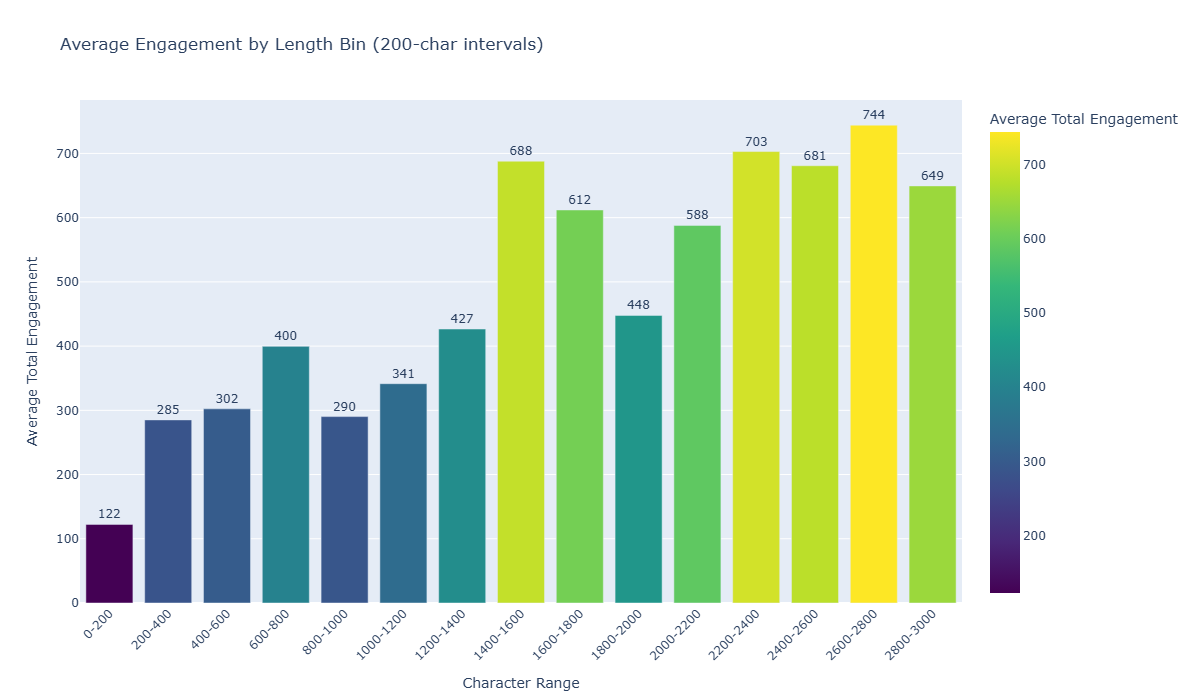

In [8]:
# Bar chart of engagement by length bins
fig = px.bar(
    length_bin_stats_filtered,
    x='length_bin',
    y='avg_engagement',
    title='Average Engagement by Length Bin (200-char intervals)',
    labels={'length_bin': 'Character Range', 'avg_engagement': 'Average Total Engagement'},
    text='avg_engagement',
    color='avg_engagement',
    color_continuous_scale='Viridis',
    hover_data=['post_count', 'median_engagement']
)

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(height=600, xaxis_tickangle=-45, showlegend=False)
fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/engagement_by_length_bins.html')

In [9]:
# Find optimal length ranges
top_3_bins = length_bin_stats_filtered.nlargest(3, 'avg_engagement')

print("\nTop 3 Length Ranges by Average Engagement:")
print(top_3_bins[['length_bin', 'avg_engagement', 'post_count', 'median_engagement']].to_string(index=False))


Top 3 Length Ranges by Average Engagement:
length_bin  avg_engagement  post_count  median_engagement
 2600-2800          744.04          77             328.00
 2200-2400          702.93         126             336.50
 1400-1600          687.94         379             250.00


### 2.3 Length Analysis by Content Type

In [10]:
# Analyze optimal length for each content type
content_length_analysis = df_with_text.groupby(['primary_content_type', 'length_category']).agg({
    'total_engagement': ['mean', 'count']
}).round(2)

content_length_analysis.columns = ['avg_engagement', 'post_count']
content_length_analysis = content_length_analysis.reset_index()

# Filter to content types with significant posts
major_content_types = ['Image', 'Video', 'Article', 'Text Only', 'Reshare']
content_length_filtered = content_length_analysis[content_length_analysis['primary_content_type'].isin(major_content_types)]

print("Engagement by Content Type × Length Category:")
print(content_length_filtered.to_string(index=False))

content_length_filtered.to_csv('../output/tables/content_type_length_interaction.csv', index=False)

Engagement by Content Type × Length Category:
primary_content_type length_category  avg_engagement  post_count
             Article            Long          266.33         496
             Article          Medium          229.08         559
             Article           Short          153.08         359
             Article       Very Long          530.46         135
             Article      Very Short          144.06          70
               Image            Long          412.49        1213
               Image          Medium          456.38        1304
               Image           Short          360.15         738
               Image       Very Long          627.24         574
               Image      Very Short          301.55         139
             Reshare            Long          126.48         207
             Reshare          Medium           65.63         580
             Reshare           Short           47.58        1000
             Reshare       Very Long        

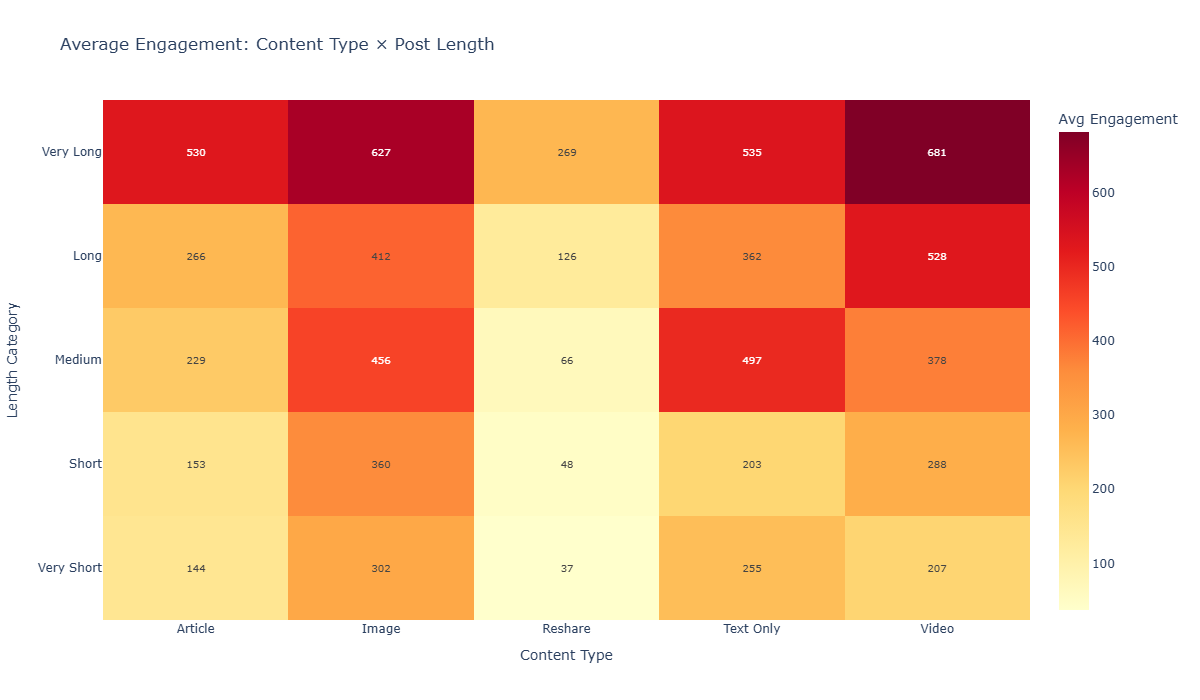

In [11]:
# Create 2D heatmap: Content Type × Length Category
heatmap_data = content_length_filtered.pivot(index='length_category', columns='primary_content_type', values='avg_engagement')

# Reorder length categories
length_order = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
heatmap_data = heatmap_data.reindex(length_order)

fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='YlOrRd',
    text=heatmap_data.values,
    texttemplate='%{text:.0f}',
    textfont={"size": 10},
    colorbar=dict(title="Avg Engagement")
))

fig.update_layout(
    title='Average Engagement: Content Type × Post Length',
    xaxis_title='Content Type',
    yaxis_title='Length Category',
    height=500,
    width=900
)

fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/content_type_length_heatmap.html')

## 3. Statistical Significance Testing

### 3.1 Content Type Differences

In [12]:
# Kruskal-Wallis test for content type differences (non-parametric)
content_groups = [df[df['primary_content_type'] == ct]['total_engagement'].values 
                  for ct in major_content_types]

h_stat, p_value = kruskal(*content_groups)

print("Kruskal-Wallis Test: Content Type Differences")
print(f"H-statistic: {h_stat:.2f}")
print(f"P-value: {p_value:.6f}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")

Kruskal-Wallis Test: Content Type Differences
H-statistic: 3069.25
P-value: 0.000000
Significant: Yes


In [13]:
# Pairwise comparisons: Video vs other types
video_engagement = df[df['primary_content_type'] == 'Video']['total_engagement'].values

pairwise_results = []

for content_type in ['Image', 'Article', 'Text Only', 'Reshare']:
    other_engagement = df[df['primary_content_type'] == content_type]['total_engagement'].values
    
    u_stat, p_val = mannwhitneyu(video_engagement, other_engagement, alternative='two-sided')
    
    # Calculate effect size (Cohen's d approximation)
    mean_diff = np.mean(video_engagement) - np.mean(other_engagement)
    pooled_std = np.sqrt((np.std(video_engagement)**2 + np.std(other_engagement)**2) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
    
    pairwise_results.append({
        'Comparison': f'Video vs {content_type}',
        'Video_Mean': np.mean(video_engagement),
        'Other_Mean': np.mean(other_engagement),
        'Difference': mean_diff,
        'P_Value': p_val,
        'Significant': 'Yes' if p_val < 0.05 else 'No',
        'Cohens_D': cohens_d,
        'Effect_Size': 'Small' if abs(cohens_d) < 0.5 else ('Medium' if abs(cohens_d) < 0.8 else 'Large')
    })

pairwise_df = pd.DataFrame(pairwise_results)
print("\nPairwise Comparisons: Video vs Other Content Types")
print(pairwise_df.to_string(index=False))

pairwise_df.to_csv('../output/tables/content_type_statistical_tests.csv', index=False)


Pairwise Comparisons: Video vs Other Content Types
        Comparison  Video_Mean  Other_Mean  Difference  P_Value Significant  Cohens_D Effect_Size
    Video vs Image      461.22      444.38       16.84     0.01         Yes      0.02       Small
  Video vs Article      461.22      248.99      212.23     0.00         Yes      0.27       Small
Video vs Text Only      461.22      402.11       59.11     0.01         Yes      0.06       Small
  Video vs Reshare      461.22       58.58      402.64     0.00         Yes      0.57      Medium


### 3.2 Text Feature Impact Tests

In [14]:
# Statistical tests for text features
text_feature_tests = []

features = {
    'has_url': 'URLs',
    'has_question': 'Questions',
    'has_emoji': 'Emojis',
    'has_hashtag': 'Hashtags'
}

for feature, label in features.items():
    with_feature = df[df[feature] == True]['total_engagement'].values
    without_feature = df[df[feature] == False]['total_engagement'].values
    
    u_stat, p_val = mannwhitneyu(with_feature, without_feature, alternative='two-sided')
    
    mean_with = np.mean(with_feature)
    mean_without = np.mean(without_feature)
    diff_pct = ((mean_with - mean_without) / mean_without * 100)
    
    # Effect size
    pooled_std = np.sqrt((np.std(with_feature)**2 + np.std(without_feature)**2) / 2)
    cohens_d = (mean_with - mean_without) / pooled_std if pooled_std > 0 else 0
    
    text_feature_tests.append({
        'Feature': label,
        'With_Feature_Mean': mean_with,
        'Without_Feature_Mean': mean_without,
        'Difference_%': diff_pct,
        'P_Value': p_val,
        'Significant': 'Yes' if p_val < 0.05 else 'No',
        'Cohens_D': cohens_d,
        'Effect_Size': 'Small' if abs(cohens_d) < 0.5 else ('Medium' if abs(cohens_d) < 0.8 else 'Large')
    })

text_features_df = pd.DataFrame(text_feature_tests)
print("\nText Feature Impact - Statistical Tests")
print(text_features_df.to_string(index=False))

text_features_df.to_csv('../output/tables/text_feature_statistical_tests.csv', index=False)


Text Feature Impact - Statistical Tests
  Feature  With_Feature_Mean  Without_Feature_Mean  Difference_%  P_Value Significant  Cohens_D Effect_Size
     URLs             430.39                290.31         48.25     0.00         Yes      0.14       Small
Questions             342.58                324.14          5.69     0.00         Yes      0.02       Small
   Emojis             280.70                346.28        -18.94     0.08          No     -0.08       Small
 Hashtags             317.62                329.72         -3.67     0.07          No     -0.02       Small


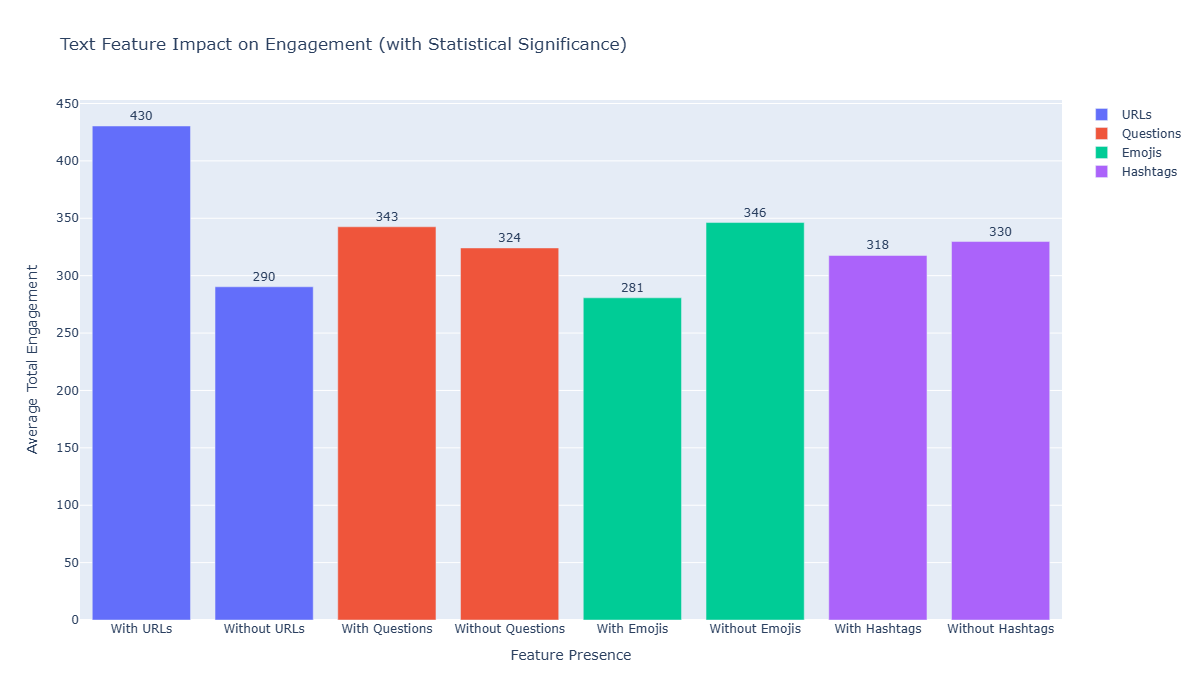

In [15]:
# Visualize text feature impact with significance markers
fig = go.Figure()

for idx, row in text_features_df.iterrows():
    fig.add_trace(go.Bar(
        x=[f"With {row['Feature']}", f"Without {row['Feature']}"],
        y=[row['With_Feature_Mean'], row['Without_Feature_Mean']],
        name=row['Feature'],
        text=[f"{row['With_Feature_Mean']:.0f}", f"{row['Without_Feature_Mean']:.0f}"],
        textposition='outside'
    ))

fig.update_layout(
    title='Text Feature Impact on Engagement (with Statistical Significance)',
    xaxis_title='Feature Presence',
    yaxis_title='Average Total Engagement',
    barmode='group',
    height=600
)

fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/text_features_impact_statistical.html')

## 4. Engagement Ratio Analysis

### 4.1 Comment-to-Like and Share-to-Like Ratios

In [16]:
# Analyze engagement ratios by content type
ratio_analysis = df.groupby('primary_content_type').agg({
    'comment_to_like_ratio': 'mean',
    'share_to_like_ratio': 'mean',
    'numLikes': 'mean',
    'numComments': 'mean',
    'numShares': 'mean',
    'urn': 'count'
}).round(3)

ratio_analysis.columns = ['Avg_Comment_Like_Ratio', 'Avg_Share_Like_Ratio', 'Avg_Likes', 'Avg_Comments', 'Avg_Shares', 'Post_Count']
ratio_analysis = ratio_analysis.sort_values('Avg_Comment_Like_Ratio', ascending=False)

print("Engagement Ratios by Content Type:")
print(ratio_analysis)

ratio_analysis.to_csv('../output/tables/engagement_ratios_by_content_type.csv')

Engagement Ratios by Content Type:
                      Avg_Comment_Like_Ratio  Avg_Share_Like_Ratio  Avg_Likes  \
primary_content_type                                                            
Poll                                    1.86                  0.03      23.11   
Event                                   1.00                  0.27      78.40   
Text Only                               0.18                  0.04     344.39   
Video                                   0.12                  0.07     389.02   
Document                                0.10                  0.10     209.49   
Image                                   0.09                  0.05     397.32   
Article                                 0.07                  0.06     220.03   
Reshare                                 0.06                  0.03      53.01   
Unknown                                 0.03                  0.08      85.00   

                      Avg_Comments  Avg_Shares  Post_Count  
primary_cont

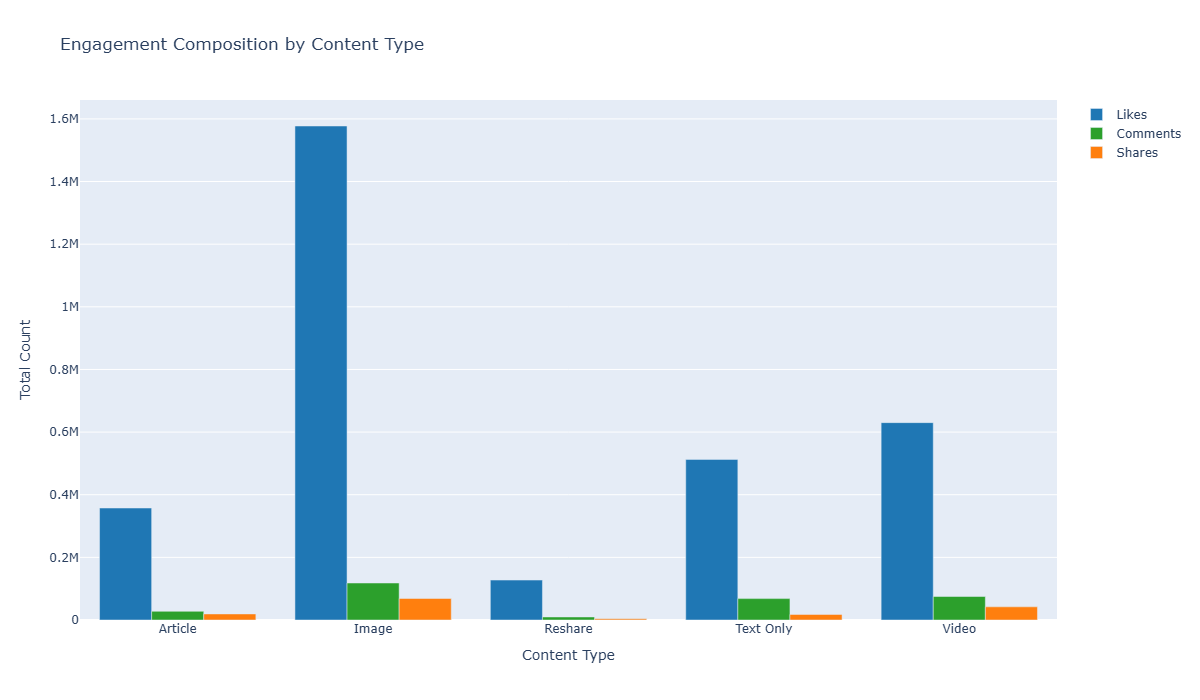

In [17]:
# Visualize engagement composition by content type
engagement_composition = df.groupby('primary_content_type').agg({
    'numLikes': 'sum',
    'numComments': 'sum',
    'numShares': 'sum'
}).reset_index()

# Filter to major content types
engagement_composition = engagement_composition[engagement_composition['primary_content_type'].isin(major_content_types)]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=engagement_composition['primary_content_type'],
    y=engagement_composition['numLikes'],
    name='Likes',
    marker_color='#1f77b4'
))

fig.add_trace(go.Bar(
    x=engagement_composition['primary_content_type'],
    y=engagement_composition['numComments'],
    name='Comments',
    marker_color='#2ca02c'
))

fig.add_trace(go.Bar(
    x=engagement_composition['primary_content_type'],
    y=engagement_composition['numShares'],
    name='Shares',
    marker_color='#ff7f0e'
))

fig.update_layout(
    title='Engagement Composition by Content Type',
    xaxis_title='Content Type',
    yaxis_title='Total Count',
    barmode='group',
    height=600
)

fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/engagement_composition_by_type.html')

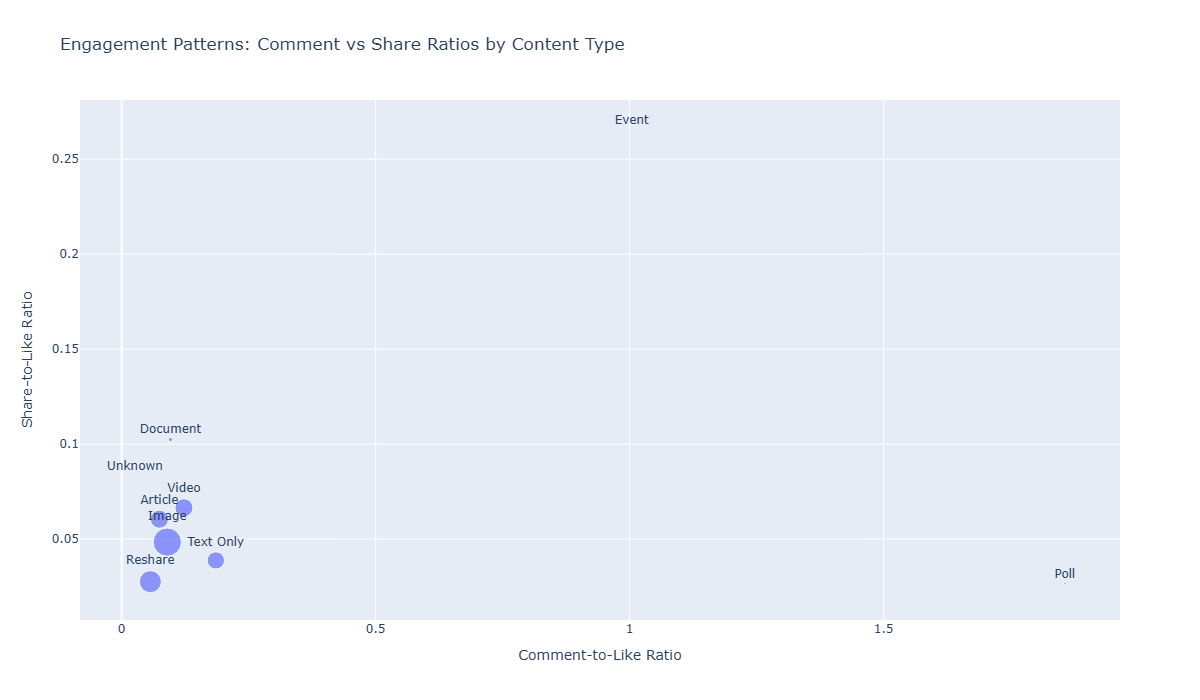

In [18]:
# Scatter: Comment ratio vs Share ratio
ratio_scatter = df.groupby('primary_content_type').agg({
    'comment_to_like_ratio': 'mean',
    'share_to_like_ratio': 'mean',
    'urn': 'count'
}).reset_index()

ratio_scatter.columns = ['Content_Type', 'Comment_Like_Ratio', 'Share_Like_Ratio', 'Post_Count']

fig = px.scatter(
    ratio_scatter,
    x='Comment_Like_Ratio',
    y='Share_Like_Ratio',
    size='Post_Count',
    text='Content_Type',
    title='Engagement Patterns: Comment vs Share Ratios by Content Type',
    labels={'Comment_Like_Ratio': 'Comment-to-Like Ratio', 'Share_Like_Ratio': 'Share-to-Like Ratio'},
    hover_data=['Post_Count']
)

fig.update_traces(textposition='top center')
fig.update_layout(height=600)
fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/comment_vs_share_ratios.html')

## 5. URL Analysis

### 5.1 Extract and Analyze URL Hosts

In [19]:
# Extract URLs from post text
def extract_urls(text):
    """Extract all URLs from text"""
    if pd.isna(text) or text == '':
        return []
    url_pattern = r'https?://[^\s]+'
    return re.findall(url_pattern, text)

def extract_domain(url):
    """Extract domain from URL"""
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        # Remove www. prefix
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return None

# Extract URLs and domains
df['extracted_urls'] = df['text'].apply(extract_urls)
df['url_domains'] = df['extracted_urls'].apply(lambda urls: [extract_domain(url) for url in urls if extract_domain(url)])

print(f"Posts with extracted URLs: {(df['extracted_urls'].str.len() > 0).sum()}")

Posts with extracted URLs: 2994


In [20]:
# Count URL hosts
all_domains = []
for domains in df['url_domains']:
    all_domains.extend(domains)

domain_counts = Counter(all_domains)
top_domains = pd.DataFrame(domain_counts.most_common(30), columns=['Domain', 'Count'])

print("\nTop 30 URL Hosts in Posts:")
print(top_domains.to_string(index=False))

top_domains.to_csv('../output/tables/top_url_hosts.csv', index=False)


Top 30 URL Hosts in Posts:
           Domain  Count
          lnkd.in   5636
           bit.ly   1062
            lu.ma     31
speedrun.a16z.com     14
         luma.com     12
         adobe.ly     10
    tech-week.com     10
     sr.a16z.com)     10
      sr.a16z.com     10
       resend.com      5
           exa.ai      5
       vercel.com      5
             t.co      4
    jobs.lsvp.com      4
     jobs.bvp.com      4
          hubs.ly      4
         lsvp.com      4
       archive.is      4
       go.clut.ch      4
      reforge.com      3
          wapo.st      3
           okt.to      3
             a.co      3
   ainative.today      3
a16zcrypto.com...      3
       legora.com      3
     thegtm10.com      3
            ow.ly      3
    jobs.lever.co      3
      shorturl.at      3


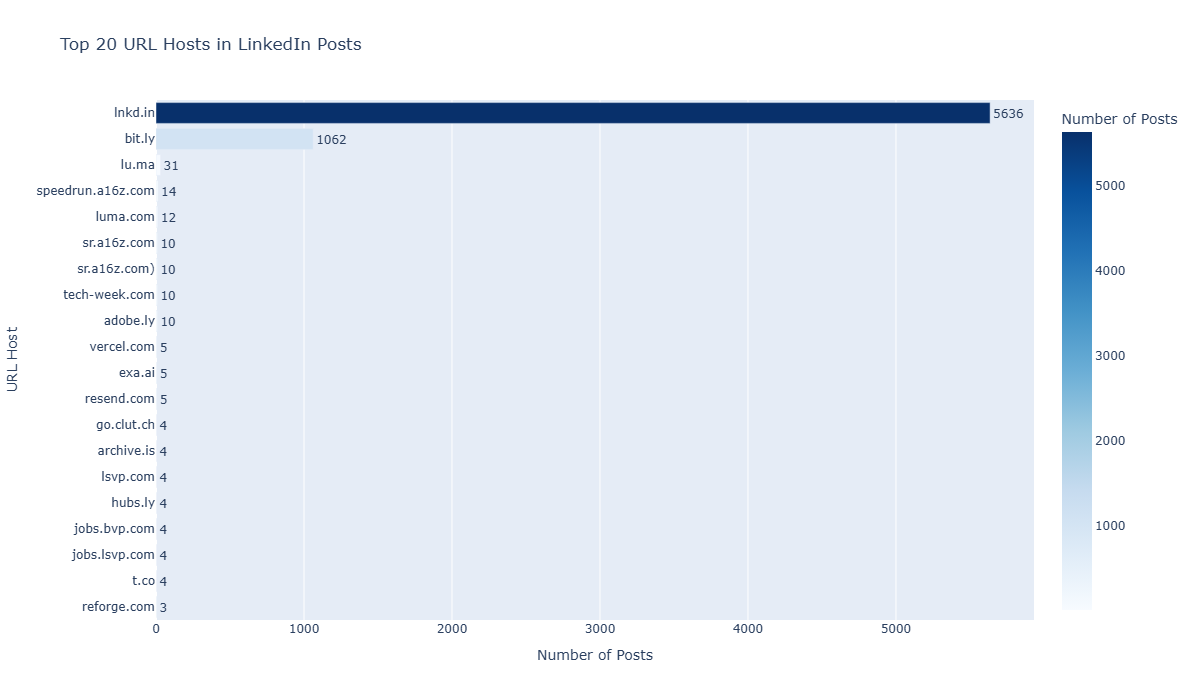

In [21]:
# Visualize top URL hosts
fig = px.bar(
    top_domains.head(20),
    x='Count',
    y='Domain',
    orientation='h',
    title='Top 20 URL Hosts in LinkedIn Posts',
    labels={'Count': 'Number of Posts', 'Domain': 'URL Host'},
    text='Count',
    color='Count',
    color_continuous_scale='Blues'
)

fig.update_traces(textposition='outside')
fig.update_layout(height=700, showlegend=False)
fig.update_yaxes(categoryorder='total ascending')
fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/top_url_hosts.html')

### 5.2 Engagement by URL Host

In [22]:
# Create dataset with primary domain (first URL in post)
df['primary_domain'] = df['url_domains'].apply(lambda x: x[0] if len(x) > 0 else None)

# Get top 15 domains and analyze engagement
top_15_domains = top_domains.head(15)['Domain'].tolist()

domain_engagement = df[df['primary_domain'].isin(top_15_domains)].groupby('primary_domain').agg({
    'total_engagement': ['mean', 'median', 'count'],
    'numLikes': 'mean',
    'numShares': 'mean',
    'numComments': 'mean'
}).round(2)

domain_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 'Avg_Likes', 'Avg_Shares', 'Avg_Comments']
domain_engagement = domain_engagement.sort_values('Avg_Engagement', ascending=False)

print("\nEngagement by Top URL Hosts:")
print(domain_engagement)

domain_engagement.to_csv('../output/tables/engagement_by_url_host.csv')


Engagement by Top URL Hosts:
                   Avg_Engagement  Median_Engagement  Post_Count  Avg_Likes  \
primary_domain                                                                
sr.a16z.com)              1839.56            2300.00           9    1509.22   
vercel.com                 981.00             981.00           1     915.00   
adobe.ly                   558.00             558.00           5     453.00   
lnkd.in                    439.58             138.00        2589     389.68   
bit.ly                     386.31             214.00         143     322.02   
t.co                       322.67             148.00           3     287.00   
resend.com                 167.75              81.00           4     154.25   
tech-week.com              150.57             151.00           7     123.29   
exa.ai                     147.40              63.00           5     132.60   
luma.com                   110.92              70.00          12      99.17   
speedrun.a16z.com     

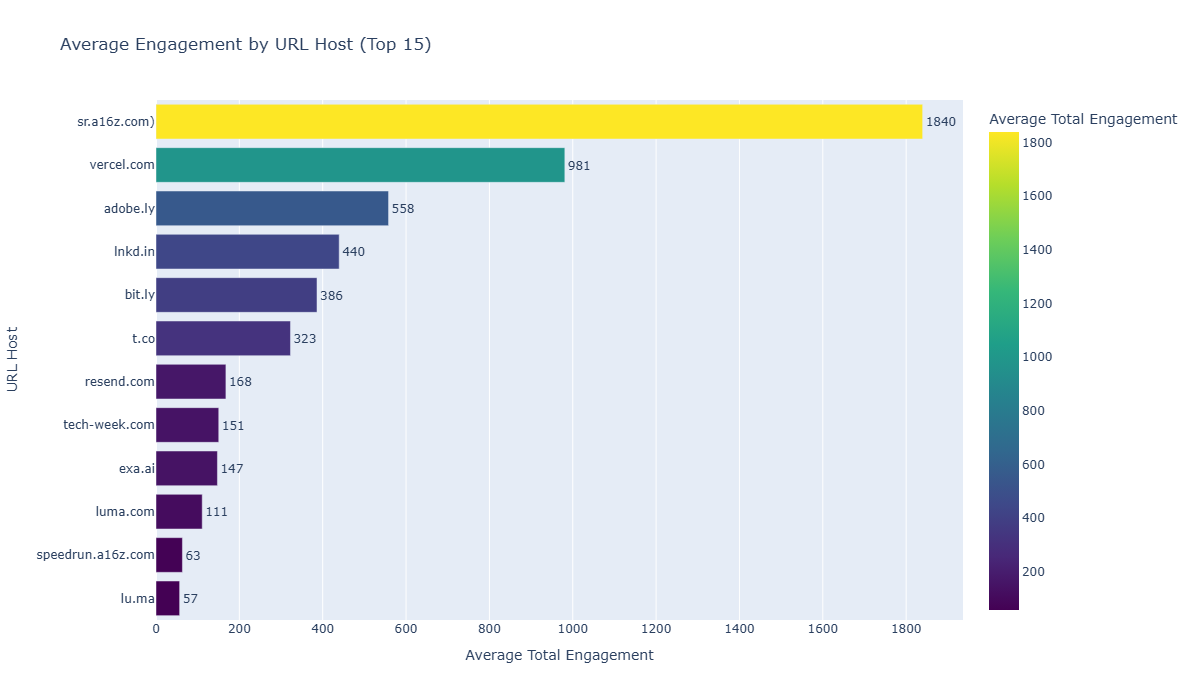

In [23]:
# Visualize engagement by URL host
domain_eng_plot = domain_engagement.reset_index()

fig = px.bar(
    domain_eng_plot,
    x='Avg_Engagement',
    y='primary_domain',
    orientation='h',
    title='Average Engagement by URL Host (Top 15)',
    labels={'Avg_Engagement': 'Average Total Engagement', 'primary_domain': 'URL Host'},
    text='Avg_Engagement',
    color='Avg_Engagement',
    color_continuous_scale='Viridis',
    hover_data=['Post_Count', 'Median_Engagement']
)

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(height=600, showlegend=False)
fig.update_yaxes(categoryorder='total ascending')
fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/engagement_by_url_host.html')

## 6. Follower Count Impact

### 6.1 Analyze Follower Count vs Engagement

In [24]:
# Filter posts with follower count data
df_with_followers = df[df['authorFollowersCount'].notna()].copy()

print(f"Posts with follower data: {len(df_with_followers)} ({len(df_with_followers)/len(df)*100:.1f}%)")

if len(df_with_followers) > 100:
    # Create follower tiers
    df_with_followers['follower_tier'] = pd.cut(
        df_with_followers['authorFollowersCount'],
        bins=[0, 10000, 100000, 1000000, float('inf')],
        labels=['<10K', '10K-100K', '100K-1M', '>1M']
    )
    
    # Engagement by follower tier
    follower_tier_engagement = df_with_followers.groupby('follower_tier').agg({
        'total_engagement': ['mean', 'median', 'count'],
        'engagement_per_follower': ['mean', 'median'],
        'authorFollowersCount': 'mean'
    }).round(4)
    
    follower_tier_engagement.columns = ['Avg_Engagement', 'Median_Engagement', 'Post_Count', 
                                         'Avg_Eng_Per_Follower', 'Median_Eng_Per_Follower', 'Avg_Followers']
    
    print("\nEngagement by Follower Tier:")
    print(follower_tier_engagement)
    
    follower_tier_engagement.to_csv('../output/tables/engagement_by_follower_tier.csv')

Posts with follower data: 1146 (10.2%)

Engagement by Follower Tier:
               Avg_Engagement  Median_Engagement  Post_Count  \
follower_tier                                                  
<10K                    82.02              52.00         333   
10K-100K               273.80             116.00         445   
100K-1M                917.39             177.00         314   
>1M                   2599.48            1112.50          54   

               Avg_Eng_Per_Follower  Median_Eng_Per_Follower  Avg_Followers  
follower_tier                                                                
<10K                           0.04                     0.01        4657.34  
10K-100K                       0.01                     0.00       37060.27  
100K-1M                        0.00                     0.00      310182.23  
>1M                            0.00                     0.00     3305171.04  


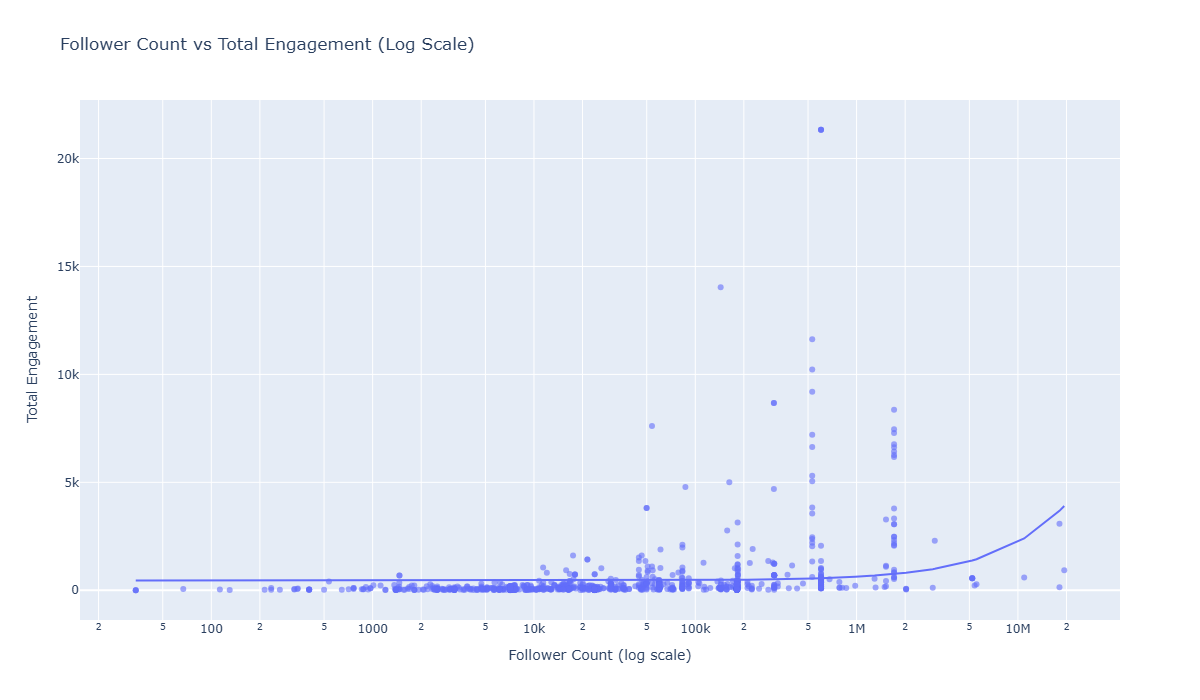

In [25]:
# Scatter plot: Follower count vs engagement
if len(df_with_followers) > 100:
    fig = px.scatter(
        df_with_followers.sample(min(1000, len(df_with_followers))),
        x='authorFollowersCount',
        y='total_engagement',
        log_x=True,
        title='Follower Count vs Total Engagement (Log Scale)',
        labels={'authorFollowersCount': 'Follower Count (log scale)', 'total_engagement': 'Total Engagement'},
        opacity=0.6,
        trendline='ols',
        hover_data=['authorName', 'primary_content_type']
    )
    
    fig.update_layout(height=600)
    fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
    fig.write_html('../output/figures/followers_vs_engagement_scatter.html')

In [26]:
# Engagement rate (engagement per follower) analysis
if len(df_with_followers) > 100:
    # Find overperformers and underperformers
    median_eng_rate = df_with_followers['engagement_per_follower'].median()
    
    overperformers = df_with_followers[df_with_followers['engagement_per_follower'] > median_eng_rate * 2]
    underperformers = df_with_followers[
        (df_with_followers['authorFollowersCount'] > 100000) & 
        (df_with_followers['engagement_per_follower'] < median_eng_rate * 0.5)
    ]
    
    print(f"\nOverperformers (>2x median engagement rate): {len(overperformers)}")
    print(f"Underperformers (>100K followers but <0.5x median rate): {len(underperformers)}")
    
    # Correlation between followers and engagement
    corr, p_val = spearmanr(df_with_followers['authorFollowersCount'], df_with_followers['total_engagement'])
    print(f"\nSpearman correlation (followers vs engagement): {corr:.3f} (p={p_val:.6f})")


Overperformers (>2x median engagement rate): 372
Underperformers (>100K followers but <0.5x median rate): 279

Spearman correlation (followers vs engagement): 0.506 (p=0.000000)


## 7. Top Performing Posts Analysis

### 7.1 Characteristics of Viral Posts

In [27]:
# Define top 1% as viral posts
engagement_threshold = df['total_engagement'].quantile(0.99)
viral_posts = df[df['total_engagement'] >= engagement_threshold].copy()

print(f"Viral posts (top 1%): {len(viral_posts)}")
print(f"Engagement threshold: {engagement_threshold:.0f}")
print(f"\nViral post characteristics:")
print(f"  Avg engagement: {viral_posts['total_engagement'].mean():.0f}")
print(f"  Avg text length: {viral_posts['text_length'].mean():.0f} chars")
print(f"\nContent type distribution:")
print(viral_posts['primary_content_type'].value_counts())

Viral posts (top 1%): 113
Engagement threshold: 3469

Viral post characteristics:
  Avg engagement: 6590
  Avg text length: 982 chars

Content type distribution:
primary_content_type
Image        70
Video        18
Article      13
Text Only    10
Reshare       1
Document      1
Name: count, dtype: int64


In [28]:
# Compare viral vs regular posts
regular_posts = df[df['total_engagement'] < df['total_engagement'].median()]

comparison_features = ['text_length', 'has_url', 'has_question', 'has_emoji', 'has_hashtag', 'num_images']

viral_vs_regular = pd.DataFrame({
    'Feature': comparison_features,
    'Viral_Mean': [viral_posts[f].mean() for f in comparison_features],
    'Regular_Mean': [regular_posts[f].mean() for f in comparison_features],
}).round(2)

viral_vs_regular['Difference_%'] = ((viral_vs_regular['Viral_Mean'] - viral_vs_regular['Regular_Mean']) / 
                                     viral_vs_regular['Regular_Mean'] * 100).round(1)

print("\nViral vs Regular Posts Comparison:")
print(viral_vs_regular.to_string(index=False))

viral_vs_regular.to_csv('../output/tables/viral_vs_regular_comparison.csv', index=False)


Viral vs Regular Posts Comparison:
     Feature  Viral_Mean  Regular_Mean  Difference_%
 text_length      981.86        516.32         90.20
     has_url        0.45          0.23         95.70
has_question        0.19          0.17         11.80
   has_emoji        0.17          0.29        -41.40
 has_hashtag        0.09          0.17        -47.10
  num_images        0.73          0.38         92.10


## 8. Predictive Analysis

### 8.1 Feature Importance for Engagement

In [29]:
# Prepare features for regression
feature_cols = ['text_length', 'word_count', 'has_url', 'has_question', 'has_emoji', 
                'has_hashtag', 'hashtag_count', 'url_count', 'num_images', 'is_weekend']

# Add content type dummies
df_model = df.copy()
content_dummies = pd.get_dummies(df_model['primary_content_type'], prefix='content')
df_model = pd.concat([df_model, content_dummies], axis=1)

# Prepare X and y
X_features = feature_cols + [col for col in content_dummies.columns]
X = df_model[X_features].copy()

# Convert boolean to int
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

y = df_model['total_engagement']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit linear regression
model = LinearRegression()
model.fit(X_scaled, y)

# Get feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False, key=abs)

print("\nFeature Importance (Linear Regression Coefficients):")
print(feature_importance.to_string(index=False))

print(f"\nModel R² Score: {model.score(X_scaled, y):.4f}")

feature_importance.to_csv('../output/tables/feature_importance_regression.csv', index=False)


Feature Importance (Linear Regression Coefficients):
          Feature  Coefficient
       word_count       217.42
      text_length      -104.09
  content_Reshare       -86.24
    content_Image        62.47
        has_emoji       -57.56
      has_hashtag       -55.44
     has_question       -46.38
    hashtag_count        42.21
          has_url        41.24
    content_Video        38.89
       is_weekend        34.72
  content_Article       -34.19
       num_images       -27.66
content_Text Only        15.63
 content_Document        -9.90
        url_count         9.02
     content_Poll        -8.86
    content_Event        -4.25
  content_Unknown        -2.92

Model R² Score: 0.0534


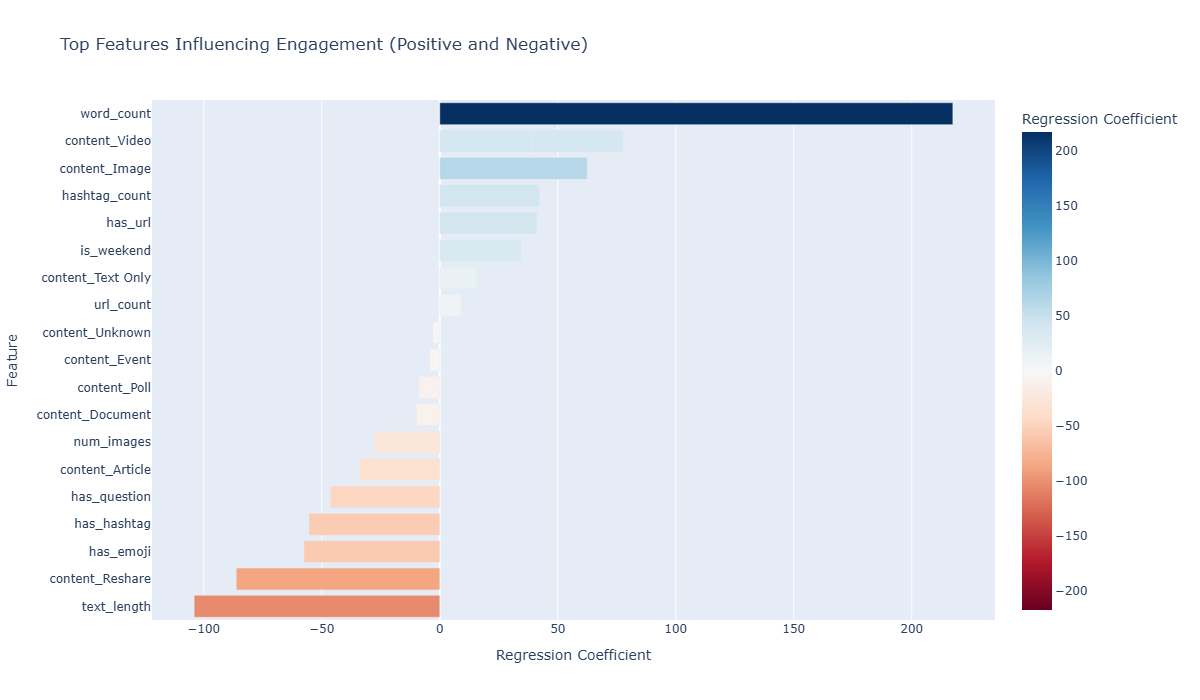

In [30]:
# Visualize top feature importance
top_features = pd.concat([
    feature_importance.head(10),
    feature_importance.tail(10)
])

fig = px.bar(
    top_features,
    x='Coefficient',
    y='Feature',
    orientation='h',
    title='Top Features Influencing Engagement (Positive and Negative)',
    labels={'Coefficient': 'Regression Coefficient', 'Feature': 'Feature'},
    color='Coefficient',
    color_continuous_scale='RdBu',
    color_continuous_midpoint=0
)

fig.update_layout(height=700)
fig.update_yaxes(categoryorder='total ascending')
fig.show()

# Display static image for GitHub preview
from IPython.display import Image, display
import plotly.io as pio
try:
    img_bytes = pio.to_image(fig, format="png", width=1200, height=700)
    display(Image(img_bytes))
except Exception as e:
    print("Install kaleido: pip install kaleido")
fig.write_html('../output/figures/feature_importance.html')

## 9. Key Findings Summary

In [31]:
print("="*70)
print("KEY FINDINGS: ENGAGEMENT ANALYSIS")
print("="*70)

findings = []

# 1. Optimal length
if len(length_bin_stats_filtered) > 0:
    best_bin = length_bin_stats_filtered.nlargest(1, 'avg_engagement').iloc[0]
    findings.append(f"1. Optimal Post Length: {best_bin['length_bin']} characters (Avg engagement: {best_bin['avg_engagement']:.0f})")

# 2. Content type winner
findings.append(f"2. Video content leads in engagement but is it statistically significant?")
video_vs_image = pairwise_df[pairwise_df['Comparison'] == 'Video vs Image'].iloc[0]
findings.append(f"   - Video vs Image: p={video_vs_image['P_Value']:.4f}, Effect: {video_vs_image['Effect_Size']}")

# 3. URL impact
url_test = text_features_df[text_features_df['Feature'] == 'URLs'].iloc[0]
findings.append(f"3. URLs boost engagement by {url_test['Difference_%']:.1f}% (p={url_test['P_Value']:.4f})")

# 4. Top URL hosts
if len(top_domains) > 0:
    top_3_hosts = top_domains.head(3)
    findings.append(f"4. Top URL hosts: {', '.join(top_3_hosts['Domain'].tolist())}")

# 5. Engagement ratios
findings.append(f"5. Comment-to-Like ratio varies by content:")
top_comment_type = ratio_analysis.nlargest(1, 'Avg_Comment_Like_Ratio').index[0]
findings.append(f"   - Highest: {top_comment_type} ({ratio_analysis.loc[top_comment_type, 'Avg_Comment_Like_Ratio']:.3f})")

# 6. Follower impact
if len(df_with_followers) > 100:
    findings.append(f"6. Follower count correlation with engagement: {corr:.3f} (moderate positive)")

# 7. Viral characteristics
findings.append(f"7. Viral posts (top 1%) have {viral_posts['text_length'].mean():.0f} avg chars")

for finding in findings:
    print(finding)

print("="*70)

# Save findings
with open('../output/tables/key_findings_engagement.txt', 'w') as f:
    f.write("KEY FINDINGS: ENGAGEMENT ANALYSIS\n")
    f.write("="*70 + "\n")
    for finding in findings:
        f.write(finding + "\n")

KEY FINDINGS: ENGAGEMENT ANALYSIS
1. Optimal Post Length: 2600-2800 characters (Avg engagement: 744)
2. Video content leads in engagement but is it statistically significant?
   - Video vs Image: p=0.0115, Effect: Small
3. URLs boost engagement by 48.3% (p=0.0000)
4. Top URL hosts: lnkd.in, bit.ly, lu.ma
5. Comment-to-Like ratio varies by content:
   - Highest: Poll (1.857)
6. Follower count correlation with engagement: 0.506 (moderate positive)
7. Viral posts (top 1%) have 982 avg chars
